In [18]:
# import necessary packages
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities, matutils

sns.set_style('ticks')

## Exploratory Data Analysis
Now that the document-term matrices have been created, I will explore the data to ensure that the corpus is in a suitable format to run sentiment analysis.

In [2]:
# read in the cleaned data
data = pd.read_pickle('corpus.pkl')
data.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,alexrcamacho by not shipping it
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,i ordered the escobar fold never got iti order...
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,harshb supersaf beebomco howtomen verge cnet m...
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,alijahsimon jonprosser android n customization...
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,andrewmartonik it’s possible my scale isn’t pe...


In [3]:
# instantiate word cloud
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

In [4]:
# Combine all of the tweets into a single string
all_tweets = [tweet for tweet in data['text']]
all_tweets = ' '.join(all_tweets)

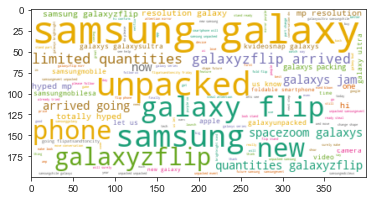

In [5]:
# generate word cloud from all tweets
cloud_tweets = wc.generate(all_tweets)

plt.imshow(cloud_tweets, interpolation='bilinear');

Dope! No words really stick out as outliers here. It looks like the major words are all relevant to the Samsung event and/or features of the phone which is exactly what I want.

## Sentiment Analysis
My main objective is to accurately assign sentiment scores to the tweets and determine which features/aspects of the phone corresponded to each emotion. 

In [6]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity'] = data['text'].apply(pol)
data['subjectivity'] = data['text'].apply(sub)
data.head()

,id_str,created_at,screen_name,in_reply_to_status_id_str,in_reply_to_screen_name,favorite_count,retweet_count,text,polarity,subjectivity
0,1230661597519138816,2020-02-21 01:12:44+00:00,MKBHD,1.230659e+18,AlexRCamacho1,851,7,alexrcamacho by not shipping it,0.0,0.0
1,1230648790526386176,2020-02-21 00:21:50+00:00,MKBHD,NaN,None,8204,297,i ordered the escobar fold never got iti order...,0.0,0.0
2,1230581789619519488,2020-02-20 19:55:36+00:00,MKBHD,1.230581e+18,harshb_,25,1,harshb supersaf beebomco howtomen verge cnet m...,0.0,0.0
3,1230566950989942784,2020-02-20 18:56:38+00:00,MKBHD,1.230534e+18,AlijahSimon,170,2,alijahsimon jonprosser android n customization...,0.0,0.0
4,1230535104214294528,2020-02-20 16:50:05+00:00,MKBHD,1.230534e+18,andrewmartonik,245,2,andrewmartonik it’s possible my scale isn’t pe...,0.5,1.0


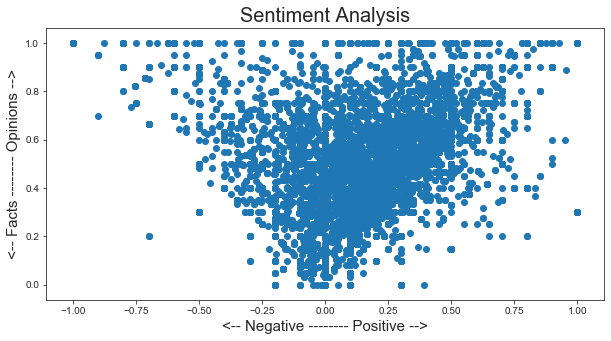

In [7]:
plt.figure(figsize=(10,5))

x = data.polarity
y = data.subjectivity
plt.scatter(x, y)
# plt.text(x+.001, y+.001, data['screen_name'][index], fontsize=10)
# plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15);

## Sentiment over time
- Group by day and concatenate the tweets for that day into one document.
- Run sentiment analysis again on grouped data and plot with a line graph and curve/scatter.

## Clustering

In [8]:
# read in the document-term matricex
data_count = pd.read_pickle('dtm_count.pkl')
data_count.head()

,aa,aaaaa,aaaaah,aaaaand,aaaawwww,aadmi,aakarsha,aamaadmiparti,aapkidilli,aapl,...,𝗮𝘄𝗮𝘆,𝗳𝗮𝗰𝘂𝗹𝘁𝘆,𝗳𝗹𝘂𝘅,𝗶𝘀,𝗻𝗼𝘁,𝘁𝗮𝗸𝗲𝘀,𝘁𝗵𝗮𝘁,𝘂𝘀𝗲𝗱,𝙃enlivenphtoalltheboy,𝙒𝙍𝙄enlivenphthirdlookat
alexrcamacho by not ship it...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i order the escobar fold never...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
harshb supersaf beebomco howto...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alijahsimon jonpross android n...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
andrewmartonik it ’ s possibl ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
cls = MiniBatchKMeans(n_clusters=5, random_state=42)
cls.fit(np.array(data_count))

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

### PCA

In [10]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(np.array(data_count))

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

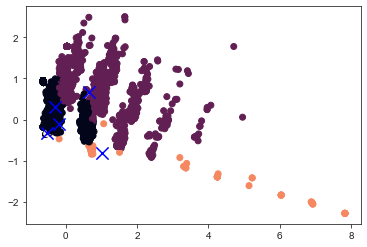

In [11]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(np.array(data_count)))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b');

### LDA

#### Pre-process text

In [31]:
# read in cleaned text to model
data = pd.read_pickle('corpus.pkl')
corpus = list(data.text)

In [32]:
# create a CountVectorizer
countVectorizer = CountVectorizer(stop_words='english')
countVectorizer.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [33]:
# create the term-document matrix
doc_word = countVectorizer.transform(corpus).transpose()

In [34]:
# convert sparse matrix of counts to a gensim corpus
gensim_corpus = matutils.Sparse2Corpus(doc_word)

In [35]:
id2word = dict((v, k) for k, v in countVectorizer.vocabulary_.items())

#### Run LDA model

In [30]:
# create lda model
lda = models.LdaModel(corpus=gensim_corpus, num_topics=3, id2word=id2word, passes=100)

KeyboardInterrupt: 

In [ ]:
lda_corpus = lda[corpus]

In [ ]:
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:5]

## NMF
Just through this in there

In [36]:
# create a CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(corpus)

In [37]:
# instantiate nmf model
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [38]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [40]:
# display topics and words associated
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
samsung, galaxy, flip, new, ultra, galaxyzflip, phone, series, fold, future

Topic  1
galaxys, mp, samsungchile, resolution, hyped, totally, packing, spacezoom, jam, galaxysultra

Topic  2
galaxyzflip, going, friday, limited, arrived, quantities, flipatsandtoncity, flipatgateway, flipatcanalwalk, flip

Topic  3
unpacked, samsungevent, samsungmobilesa, new, event, samsungmobile, just, live, watch, samsungmobileus

Topic  4
foldable, look, smartphone, make, stand, mirror, ready, purple, attention, surely
